# Maze Robot GA Simulation

This notebook runs the Genetic Algorithm simulation for maze robot navigation in a headless environment and captures video for visualization.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pygame
import os
import sys
import time
import cv2
from IPython.display import HTML, display
from base64 import b64encode
from IPython.display import Video

# Import project modules
from Robot_config import Robot
from Environment import Environment
from class_GA import Genetic_Algo
from ClassNeuralNetwork import NeuralNet
from cost_calculate import calculate_cost

pygame 2.6.1 (SDL 2.28.4, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Setup headless pygame
os.environ["SDL_VIDEODRIVER"] = "dummy"
pygame.init()

# Configure video recording
def setup_video_writer(filename, fps=30, size=(900, 900)):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
    return cv2.VideoWriter(filename, fourcc, fps, size)

In [3]:
# Helper function to convert pygame surface to numpy array for OpenCV
def surface_to_array(surface):
    return np.transpose(np.array(pygame.surfarray.pixels3d(surface)), (1, 0, 2))

In [4]:
# Function to display video in the notebook
def show_video(file_path, width=640):
    return Video(file_path, width=width)

In [5]:
def run_ga_simulation(generations=20, population_size=30, video_filename="ga_simulation.mp4", record_interval=1):
    # Record only certain generations to keep video size manageable
    record_generations = set([0, generations//4, generations//2, generations-1])
    
    # Load map
    map = pygame.image.load("./maze.jpg")
    map_copy = map.copy()
    
    # Start position & size maze
    start_position = (450, 100)  # origin 450, 100
    end_position = (450, 900, -np.pi/2)
    size = (900, 900)
    
    environment = Environment(size, "./maze.jpg")
    
    # Setup robots
    numbers = population_size
    Robots = []
    for i in range(numbers):
        Robots.append(Robot(start_position, "./car.png", 2, 2))
    
    # GA init
    pop = numbers
    GA_init = Genetic_Algo([-5, 5], (-5, 5), population_size, 130, 12)
    population = GA_init.create_population()
    
    generation = 0
    max_generation = generations
    
    # Video writer
    video_writer = setup_video_writer(video_filename)
    
    # Metrics to track
    min_fitness_history = []
    mean_fitness_history = []
    best_distance_history = []
    
    # Main loop
    while generation < max_generation:
        print(f"Processing generation {generation+1}/{max_generation}")
        
        # Setup for video recording of this generation
        record_this_gen = generation in record_generations
        frame_counter = 0
        
        Robot_available = pop
        decode = GA_init.decode_gen(population)
        
        for idx, robot in enumerate(Robots):
            robot.x = start_position[0]
            robot.y = start_position[1]
            robot.theta = np.pi
            
            robot.vx = 0
            robot.time = 0
            robot.update_sensor_data(map_copy, (0, 0, 0))
            robot.check_crash(map_copy, (0, 0, 0))
            robot.crash = False
            robot.cost_function = 0
            robot.N = 0
        
        dt = 0.05  # Fixed dt for simulation stability
        
        while Robot_available > 0:
            # Clear display surface
            environment.map.blit(map, (0, 0))
            
            for idx, robot in enumerate(Robots):
                if not robot.crash:
                    # Neural network control
                    decode_individual = decode[idx]
                    w = np.reshape(decode_individual[:110], (11, 10))
                    v = np.reshape(decode_individual[110:], (10, 2))
                    
                    x = np.array(robot.sensor_data + [float(robot.x), float(robot.y), float(robot.theta)]).reshape(11, 1)
                    
                    VVV = NeuralNet(x, w, v).FeedForward()
                    robot.vx = (VVV[0][0]) * 2.5
                    robot.vtheta = (VVV[1][0]) * 0.03
                    
                    # Calculate cost
                    robot.N += 1
                    score = calculate_cost(robot.x, robot.y, robot.theta, robot.x_dot, robot.y_dot, robot.sensor_valid, robot.sensor_data)
                    robot.cost_function += score.euclid_score() + score.sensor_score()
                    
                    # Move the robot
                    robot.move(dt)
                    robot.time += dt
                    robot.check_crash(map_copy, (0, 0, 0))
                    
                    if robot.crash:
                        Robot_available -= 1
                        if robot.N > 0:
                            robot.cost_function = robot.cost_function / robot.N
                    
                    # Visualization
                    if record_this_gen and frame_counter % record_interval == 0:
                        robot.draw(environment.map)
                        environment.robot_frames([robot.x, robot.y], robot.theta)
                        environment.robot_sensor([robot.x, robot.y], robot.points)
                        environment.trail((robot.x, robot.y))
                        
                        # Add generation info to frame
                        font = pygame.font.Font('freesansbold.ttf', 24)
                        text = font.render(f"Generation: {generation+1}/{max_generation}", True, (255, 255, 255), (0, 0, 0))
                        environment.map.blit(text, (10, 10))
                    
                    robot.update_sensor_data(map_copy, (0, 0, 0))
            
            # Record frame if appropriate
            if record_this_gen and frame_counter % record_interval == 0:
                frame = surface_to_array(environment.map)
                # Convert to BGR for OpenCV
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                video_writer.write(frame)
            
            frame_counter += 1
            
            # Limit simulation steps per generation to avoid infinite loops
            if frame_counter > 1000:
                # Force end if running too long
                for robot in Robots:
                    if not robot.crash:
                        robot.crash = True
                        Robot_available -= 1
                        if robot.N > 0:
                            robot.cost_function = robot.cost_function / robot.N
        
        # GA operations
        fitness = [robot.cost_function for robot in Robots]
        min_fitness = np.min(fitness)
        mean_fitness = np.mean(fitness)
        
        # Record metrics
        min_fitness_history.append(min_fitness)
        mean_fitness_history.append(mean_fitness)
        
        # Get best robot's distance to goal
        best_idx = np.argmin(fitness)
        best_robot = Robots[best_idx]
        best_distance = np.sqrt((best_robot.x - end_position[0])**2 + (best_robot.y - end_position[1])**2)
        best_distance_history.append(best_distance)
        
        # GA operations for next generation
        select_population = GA_init.selection(fitness, population)
        cross_population = GA_init.crossover(select_population)
        population = GA_init.mutation(cross_population, 0.2)
        
        print(f'Generation: {generation+1}, min_fitness: {min_fitness:.2f}, mean_fitness: {mean_fitness:.2f}, best_distance: {best_distance:.2f}')
        generation += 1
    
    # Release video writer
    video_writer.release()
    
    # Return metrics for plotting
    return min_fitness_history, mean_fitness_history, best_distance_history, video_filename

In [6]:
# Run simulation
min_fitness, mean_fitness, best_distances, video_file = run_ga_simulation(generations=30, population_size=30)

Processing generation 1/30
Generation: 1, min_fitness: 75152.38, mean_fitness: 80756.20, best_distance: 753.83
Processing generation 2/30
Generation: 2, min_fitness: 76141.30, mean_fitness: 80278.61, best_distance: 746.61
Processing generation 3/30
Generation: 3, min_fitness: 76438.98, mean_fitness: 80709.08, best_distance: 754.43
Processing generation 4/30
Generation: 4, min_fitness: 75008.22, mean_fitness: 79942.67, best_distance: 743.76
Processing generation 5/30
Generation: 5, min_fitness: 76213.84, mean_fitness: 79782.22, best_distance: 743.06
Processing generation 6/30
Generation: 6, min_fitness: 75335.07, mean_fitness: 79783.12, best_distance: 744.54
Processing generation 7/30
Generation: 7, min_fitness: 75473.36, mean_fitness: 79311.82, best_distance: 741.77
Processing generation 8/30
Generation: 8, min_fitness: 74578.11, mean_fitness: 79122.70, best_distance: 730.62
Processing generation 9/30
Generation: 9, min_fitness: 73900.20, mean_fitness: 79527.26, best_distance: 687.97
P

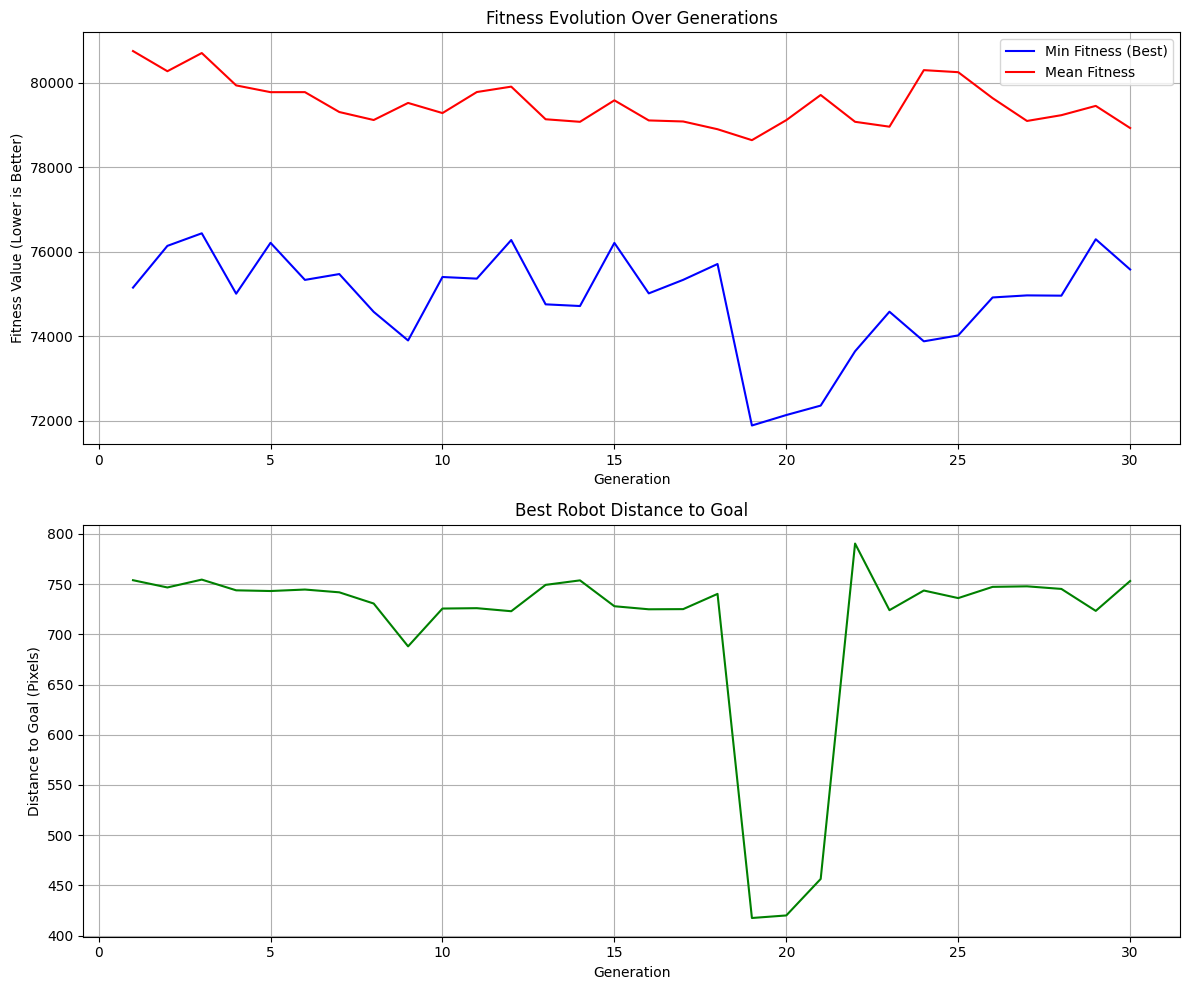

In [7]:
# Plot metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot fitness over generations
ax1.plot(range(1, len(min_fitness) + 1), min_fitness, 'b-', label='Min Fitness (Best)')
ax1.plot(range(1, len(mean_fitness) + 1), mean_fitness, 'r-', label='Mean Fitness')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness Value (Lower is Better)')
ax1.set_title('Fitness Evolution Over Generations')
ax1.grid(True)
ax1.legend()

# Plot best distance to goal over generations
ax2.plot(range(1, len(best_distances) + 1), best_distances, 'g-')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Distance to Goal (Pixels)')
ax2.set_title('Best Robot Distance to Goal')
ax2.grid(True)

plt.tight_layout()
plt.savefig('ga_metrics.png')
plt.show()

In [8]:
# Display the video
show_video(video_file, width=720)

## Compare with PPO Implementation

To run the PPO implementation, uncomment and execute the cell below. This will require that you've already implemented the PPO agent.

In [ ]:
# # Uncomment to run PPO
# import torch
# from ppo_agent import PPO
# from reward_model import RewardModel
# 
# def run_ppo_simulation(episodes=20, video_filename="ppo_simulation.mp4", record_interval=1):
#     # Similar implementation for PPO
#     # ...
#     pass
# 
# # Run PPO simulation
# # run_ppo_simulation(episodes=30)